In [1]:
import os
import cv2
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay
from PIL import Image
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import copy
import torch.nn.functional as F

In [2]:
# --- Dependencies ---
!ls /kaggle/input/facenet-pytorch-wheel
!pip install --no-deps /kaggle/input/facenet-pytorch-wheel/facenet_pytorch-2.6.0-py3-none-any.whl
from facenet_pytorch import MTCNN
import timm

facenet_pytorch-2.6.0-py3-none-any.whl
Processing /kaggle/input/facenet-pytorch-wheel/facenet_pytorch-2.6.0-py3-none-any.whl
facenet-pytorch is already installed with the same version as the provided wheel. Use --force-reinstall to force an installation of the wheel.


In [3]:
# --- Configuration ---
CONFIG = {
    "real_data_path" : [
    "/kaggle/input/celeb-df-v2/Celeb-real",
    "/kaggle/input/celeb-df-v2/YouTube-real"
] ,
    "fake_data_path": "/kaggle/input/celeb-df-v2/Celeb-synthesis",
    "max_videos_per_class": 1000, # Using a smaller number for faster iteration
    "frames_per_video": 20,      # The length of the sequence for the LSTM
    "image_size": 224,
    "batch_size": 4,             # Smaller batch size due to memory constraints of video sequences
    "epochs": 30,
    "learning_rate": 1e-4,
    "seed": 42,
    "model_name": "xception",
    "model_save_path": "./model_checkpoints_spatiotemporal",
    "early_stopping_patience": 5,
    "weight_decay": 1e-5,
}

In [4]:
# Cek real data
for path in CONFIG["real_data_path"]:
    print(f"\nIsi folder: {path}")
    files = os.listdir(path)
    print(f"Jumlah file: {len(files)}")
    print("Contoh file:", files[:5])

# Cek fake data
fake_path = CONFIG["fake_data_path"]
print(f"\nIsi folder: {fake_path}")
files = os.listdir(fake_path)
print(f"Jumlah file: {len(files)}")
print("Contoh file:", files[:5])



Isi folder: /kaggle/input/celeb-df-v2/Celeb-real
Jumlah file: 590
Contoh file: ['id49_0006.mp4', 'id27_0008.mp4', 'id32_0000.mp4', 'id1_0006.mp4', 'id50_0006.mp4']

Isi folder: /kaggle/input/celeb-df-v2/YouTube-real
Jumlah file: 300
Contoh file: ['00238.mp4', '00152.mp4', '00269.mp4', '00209.mp4', '00297.mp4']

Isi folder: /kaggle/input/celeb-df-v2/Celeb-synthesis
Jumlah file: 5639
Contoh file: ['id33_id20_0005.mp4', 'id24_id19_0004.mp4', 'id0_id3_0009.mp4', 'id51_id50_0008.mp4', 'id54_id53_0003.mp4']


In [5]:
# Reproducibility
torch.manual_seed(CONFIG["seed"])
np.random.seed(CONFIG["seed"])
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [6]:
# --- Step 1: Data Preparation for Video Sequences ---
mtcnn = MTCNN(image_size=CONFIG["image_size"], margin=0, min_face_size=20, device=device)

def prepare_video_sequences_dataset(config):
    """
    Loads videos, extracts sequences of face frames for each video.
    The output is a list of sequences, where each sequence is a list of PIL images.
    """
    print("Preparing dataset of video sequences...")
    all_sequences = []
    all_labels = []

    def process_videos(video_paths, label, desc):
        for video_path in tqdm(video_paths, desc=desc):
            cap = cv2.VideoCapture(video_path)
            if not cap.isOpened(): continue

            frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
            if frame_count < config["frames_per_video"]: continue

            frame_indices = np.linspace(0, frame_count - 1, config["frames_per_video"], dtype=int)

            video_frames = [] # To hold the sequence of frames for one video

            for i in frame_indices:
                cap.set(cv2.CAP_PROP_POS_FRAMES, i)
                ret, frame = cap.read()
                if not ret: continue

                frame_pil = Image.fromarray(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))

                # Using MTCNN to detect and get a cropped face tensor
                face_tensor = mtcnn(frame_pil)

                if face_tensor is not None:
                    # Convert tensor back to PIL Image and add to sequence
                    face_pil = transforms.ToPILImage()((face_tensor + 1) / 2) # MTCNN output is [-1, 1]
                    video_frames.append(face_pil)

            # If we have a full sequence, add it to our dataset
            if len(video_frames) == config["frames_per_video"]:
                all_sequences.append(video_frames)
                all_labels.append(label)

            cap.release()
    real_videos = []
    for path in config["real_data_path"]:
        real_videos.extend([os.path.join(path, f) for f in os.listdir(path)])
    real_videos = real_videos[:config["max_videos_per_class"]]
    process_videos(real_videos, 0, "Processing real videos")  # 0 = REAL

    fake_videos = []
    if isinstance(config["fake_data_path"], list):  # jaga-jaga kalau nanti diubah jadi list juga
        for path in config["fake_data_path"]:
            fake_videos.extend([os.path.join(path, f) for f in os.listdir(path)])
    else:
        fake_videos = [os.path.join(config["fake_data_path"], f) for f in os.listdir(config["fake_data_path"])]
    fake_videos = fake_videos[:config["max_videos_per_class"]]
    process_videos(fake_videos, 1, "Processing fake videos")  # 1 = FAKE


    #real_videos = [os.path.join(config["real_data_path"], f) for f in os.listdir(config["real_data_path"])][:config["max_videos_per_class"]]
    #process_videos(real_videos, 0, "Processing real videos") # 0 for REAL

    #fake_videos = [os.path.join(config["fake_data_path"], f) for f in os.listdir(config["fake_data_path"])][:config["max_videos_per_class"]]
    #process_videos(fake_videos, 1, "Processing fake videos") # 1 for FAKE

    # Split sequences into train, validation, and test sets
    X_train_val, X_test, y_train_val, y_test = train_test_split(
        all_sequences, all_labels, test_size=0.20, random_state=config["seed"], stratify=all_labels
    )
    X_train, X_val, y_train, y_val = train_test_split(
        X_train_val, y_train_val, test_size=0.20, random_state=config["seed"], stratify=y_train_val
    )
    return X_train, X_val, X_test, y_train, y_val, y_test

In [7]:
# --- Step 2: Create a PyTorch Dataset for Video Sequences ---
class VideoDataset(Dataset):
    def __init__(self, sequences, labels, transform):
        self.sequences = sequences
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        # Get the sequence of PIL images for the video
        sequence = self.sequences[idx]

        # Apply transformations to each frame in the sequence and stack them
        transformed_sequence = torch.stack([self.transform(frame) for frame in sequence])

        label = torch.tensor(self.labels[idx], dtype=torch.long)
        return transformed_sequence, label

In [8]:
# --- Step 3: Define the Advanced Model Architecture ---

class SpatiotemporalAttention(nn.Module):
    def __init__(self, in_channels=2048, num_frames=20):
        super(SpatiotemporalAttention, self).__init__()
        self.spatial_attention = nn.Conv2d(in_channels, 1, kernel_size=1)
        self.temporal_attention = nn.Linear(num_frames, num_frames)
        self.relu = nn.ReLU()

    def forward(self, x): # Input shape: (b, t, c, h, w)
        b, t, c, h, w = x.shape

        # Spatial Attention
        x_reshaped = x.view(b * t, c, h, w)
        sa_map = torch.sigmoid(self.spatial_attention(x_reshaped))
        x_sa = x_reshaped * sa_map
        x_sa = x_sa.view(b, t, c, h, w)

        # Temporal Attention
        # Average over spatial dimensions to get (b, t, c)
        x_pooled = F.adaptive_avg_pool2d(x.view(b, t * c, h, w), (1, 1)).view(b, t, c)
        ta_weights = torch.sigmoid(self.temporal_attention(x_pooled.transpose(1, 2))).transpose(1, 2)
        x_ta = x_sa * ta_weights.unsqueeze(-1).unsqueeze(-1)

        return self.relu(x_ta + x) # Add residual connection

In [9]:
class ConvLSTMCell(nn.Module):
    def __init__(self, input_dim, hidden_dim, kernel_size, bias):
        super(ConvLSTMCell, self).__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.kernel_size = kernel_size
        self.padding = kernel_size[0] // 2, kernel_size[1] // 2
        self.bias = bias
        self.conv = nn.Conv2d(in_channels=self.input_dim + self.hidden_dim,
                              out_channels=4 * self.hidden_dim,
                              kernel_size=self.kernel_size,
                              padding=self.padding,
                              bias=self.bias)

    def forward(self, input_tensor, cur_state):
        h_cur, c_cur = cur_state
        combined = torch.cat([input_tensor, h_cur], dim=1)
        combined_conv = self.conv(combined)
        cc_i, cc_f, cc_o, cc_g = torch.split(combined_conv, self.hidden_dim, dim=1)
        i = torch.sigmoid(cc_i)
        f = torch.sigmoid(cc_f)
        o = torch.sigmoid(cc_o)
        g = torch.tanh(cc_g)
        c_next = f * c_cur + i * g
        h_next = o * torch.tanh(c_next)
        return h_next, c_next

    def init_hidden(self, batch_size, image_size):
        height, width = image_size
        return (torch.zeros(batch_size, self.hidden_dim, height, width, device=self.conv.weight.device),
                torch.zeros(batch_size, self.hidden_dim, height, width, device=self.conv.weight.device))

In [10]:
class STA_Xception_ConvLSTM(nn.Module):
    def __init__(self, model_name="xception", num_classes=2, hidden_dim=512):
        super(STA_Xception_ConvLSTM, self).__init__()
        # Use a pre-trained Xception as the backbone
        self.backbone = timm.create_model(model_name, pretrained=True, features_only=True)
        # Find the feature dimension of the last layer
        feature_dim = self.backbone.feature_info[-1]['num_chs']

        self.attention = SpatiotemporalAttention(in_channels=feature_dim, num_frames=CONFIG['frames_per_video'])
        self.convlstm = ConvLSTMCell(input_dim=feature_dim, hidden_dim=hidden_dim, kernel_size=(3, 3), bias=True)
        self.gap = nn.AdaptiveAvgPool2d((1,1))
        self.fc = nn.Linear(hidden_dim, num_classes)

    def forward(self, x): # Input shape: (b, t, c, h, w)
        b, t, c, h, w = x.shape
        x = x.view(b * t, c, h, w)

        # Extract features from backbone
        features = self.backbone(x)
        # Get the last feature map
        feature_map = features[-1]

        # Reshape for spatiotemporal processing
        _, c_f, h_f, w_f = feature_map.shape
        feature_map = feature_map.view(b, t, c_f, h_f, w_f)

        # Apply attention
        attended_features = self.attention(feature_map)

        # Process with ConvLSTM
        h, c = self.convlstm.init_hidden(batch_size=b, image_size=(h_f, w_f))
        for time_step in range(t):
            h, c = self.convlstm(attended_features[:, time_step, :, :, :], (h, c))

        out = self.gap(h).view(b, -1)
        out = self.fc(out)
        return out

In [11]:
# --- Step 4: Training and Evaluation ---
def plot_and_save_metrics(train_loss, val_loss, train_acc, val_acc, save_path="training_metrics_spatiotemporal.png"):
    # (Plotting function remains the same as before)
    epochs_range = range(1, len(train_loss) + 1)
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1); plt.plot(epochs_range, train_loss, 'o-', label='Training Loss'); plt.plot(epochs_range, val_loss, 'o-', label='Validation Loss')
    plt.legend(loc='upper right'); plt.title('Training and Validation Loss'); plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.grid(True)
    plt.subplot(1, 2, 2); plt.plot(epochs_range, train_acc, 'o-', label='Training Accuracy'); plt.plot(epochs_range, val_acc, 'o-', label='Validation Accuracy')
    plt.legend(loc='lower right'); plt.title('Training and Validation Accuracy'); plt.xlabel('Epoch'); plt.ylabel('Accuracy (%)'); plt.grid(True)
    plt.suptitle('Model Training Metrics (Spatiotemporal Method)'); plt.tight_layout(rect=[0, 0.03, 1, 0.95]); plt.savefig(save_path); plt.show()
    print(f"Metrics plot saved to {save_path}")


def evaluate_on_test_set(model, test_loader, device):
    # (Evaluation function remains the same as before)
    model.eval()
    all_labels, all_preds, all_probs = [], [], []
    with torch.no_grad():
        for sequences, labels in tqdm(test_loader, desc="Evaluating on Test Set"):
            sequences, labels = sequences.to(device), labels.to(device)
            outputs = model(sequences); probs = torch.softmax(outputs, dim=1)[:, 1]; _, predicted = torch.max(outputs.data, 1)
            all_probs.extend(probs.cpu().numpy()); all_preds.extend(predicted.cpu().numpy()); all_labels.extend(labels.cpu().numpy())

    print("\n--- Test Set Evaluation ---")
    print(classification_report(all_labels, all_preds, target_names=['REAL', 'FAKE']))

    plt.figure(figsize=(14, 6))
    plt.subplot(1, 2, 1); fpr, tpr, _ = roc_curve(all_labels, all_probs); roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:0.2f})'); plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.title('Receiver Operating Characteristic (ROC)'); plt.legend(loc="lower right"); plt.grid(True)

    plt.subplot(1, 2, 2); cm = confusion_matrix(all_labels, all_preds); disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['REAL', 'FAKE'])
    disp.plot(cmap=plt.cm.Blues, ax=plt.gca()); plt.title('Confusion Matrix')
    plt.tight_layout(); plt.savefig("test_evaluation_results_spatiotemporal.png"); plt.show()
    print("Test evaluation plots saved to test_evaluation_results_spatiotemporal.png")

# **Step-by-step**

## **Step 0: Data**

Di sini kita akan mengklasifikasikan suatu video itu REAL (kelas 0) atau FAKE (kelas 1).

Katakanlah ada 1 video dengan ukuran (224 x 224 x 3) (RGB)\
Diproses menjadi 3 frame.

Data sekuen menjadi: [frame 1, frame 2, frame 3]

## **Step 1: Data Preparation**

### **MTCNN**
Untuk masing-masing frame, model MTCNN akan mencoba mencari dan memotong wajah dari frame. Kemudian di resize lagi menjadi (224 x 224).

### **LBP dan Gaussian Blur**
Proses ini berlaku pada masing-masing frame:
- Konversi menjadi grayscale
- apply gaussian blur supaya mengurangi noise
- apply LBP (Local Binary Pattern)
- Final texture LBP akan dikonversi kembali menjadi 3 channel
- Lakukan sampai semua frame

### **Ubah menjadi tensor**
Data tersebut diubah menjadi tensor, sehingga bentuk tensornya menjadi (batch, time, channel, height, width) = (1, 3, 3, 224, 224)

## **Step 2: Backbone Feature Extraction (Xception)**

Masing-masing frame akan diproses pada XCeption, sehingga output dari xception adalah (1, 3, 2048, 7, 7)

## **Step 3: Spatiotemporal Attention**

### **Spatial Attention**

Melihat masing-masing fitur pada (2048 x 7 x 7) dan bertanya: "area tekstur mana pada frame ini yang paling informatif?"

### **Temporal Attention**

Melihat semua frame dan bertanya: "frame mana pada sekuen ini yang memiliki pola paling aneh dibanding yang lain?"

Output: (1, 3, 2048, 7, 7)

## **Step 4: ConvLSTM**

Memproses feature maps hasil attention secara urut dari frame 1, frame 2, kemudian frame 3.

Tujuannya adalah untuk mempelajari flow atau alur pola dari frame satu ke frame selanjutnya. Maka jika ada suatu perubahan pola pola yang aneh dari pola satu ke selanjutnya, maka bisa diklasifikasikan sebagai deepfake.

output: (1, 512, 7, 7)

## **Step 5: Klasifikasi:"

Hasil dari (1, 512, 7, 7) kemudian diproses dengan **Global Average pooling**, sehingga input untuk neural networknya menjadi 512. Global Average Pooling berfungsi untuk mengambil rata-rata pada masing-masing fiturnya.

Setelah 512 input neuron itu diproses, maka akan keluar 2 output (FAKE, REAL). Dengan softmax, maka akan keluar probabilitas output tersebut apakah FAKE atau REAL.


Preparing dataset of video sequences...


Processing fake videos: 100%|██████████| 1000/1000 [21:29<00:00,  1.29s/it]
/usr/local/lib/python3.11/dist-packages/timm/models/_factory.py:126: UserWarning: Mapping deprecated model name xception to current legacy_xception.
  model = create_fn(


Dataset prepared. Train sequences: 1202, Val sequences: 301, Test sequences: 376


Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-cadene/xception-43020ad28.pth" to /root/.cache/torch/hub/checkpoints/xception-43020ad28.pth


Starting training for xception with Spatiotemporal Attention and ConvLSTM...


Epoch 1/30: 100%|██████████| 301/301 [10:59<00:00,  2.19s/it]


Epoch 1/30, Train Loss: 0.6102, Train Acc: 66.81%, Val Loss: 0.4384, Val Acc: 81.40%
Validation accuracy improved! Saving best model to ./model_checkpoints_spatiotemporal/best_model_xception.pth


Epoch 2/30: 100%|██████████| 301/301 [10:57<00:00,  2.19s/it]


Epoch 2/30, Train Loss: 0.3725, Train Acc: 85.61%, Val Loss: 0.1788, Val Acc: 94.02%
Validation accuracy improved! Saving best model to ./model_checkpoints_spatiotemporal/best_model_xception.pth


Epoch 3/30: 100%|██████████| 301/301 [10:58<00:00,  2.19s/it]


Epoch 3/30, Train Loss: 0.2571, Train Acc: 89.85%, Val Loss: 0.1486, Val Acc: 94.35%
Validation accuracy improved! Saving best model to ./model_checkpoints_spatiotemporal/best_model_xception.pth


Epoch 4/30: 100%|██████████| 301/301 [10:56<00:00,  2.18s/it]


Epoch 4/30, Train Loss: 0.1335, Train Acc: 94.34%, Val Loss: 0.1075, Val Acc: 97.01%
Validation accuracy improved! Saving best model to ./model_checkpoints_spatiotemporal/best_model_xception.pth


Epoch 5/30: 100%|██████████| 301/301 [10:57<00:00,  2.18s/it]


Epoch 5/30, Train Loss: 0.1163, Train Acc: 95.26%, Val Loss: 0.3295, Val Acc: 89.70%
Validation accuracy did not improve. Counter: 1/5


Epoch 6/30: 100%|██████████| 301/301 [10:59<00:00,  2.19s/it]


Epoch 6/30, Train Loss: 0.0659, Train Acc: 97.84%, Val Loss: 0.1360, Val Acc: 95.68%
Validation accuracy did not improve. Counter: 2/5


Epoch 7/30: 100%|██████████| 301/301 [10:59<00:00,  2.19s/it]


Epoch 7/30, Train Loss: 0.0661, Train Acc: 97.67%, Val Loss: 0.1042, Val Acc: 96.01%
Validation accuracy did not improve. Counter: 3/5


Epoch 8/30: 100%|██████████| 301/301 [11:00<00:00,  2.20s/it]


Epoch 8/30, Train Loss: 0.0627, Train Acc: 97.92%, Val Loss: 0.1566, Val Acc: 94.35%
Validation accuracy did not improve. Counter: 4/5


Epoch 9/30: 100%|██████████| 301/301 [10:59<00:00,  2.19s/it]


Epoch 9/30, Train Loss: 0.0384, Train Acc: 98.50%, Val Loss: 0.1606, Val Acc: 94.68%
Validation accuracy did not improve. Counter: 5/5
Early stopping triggered.

--- Training finished ---


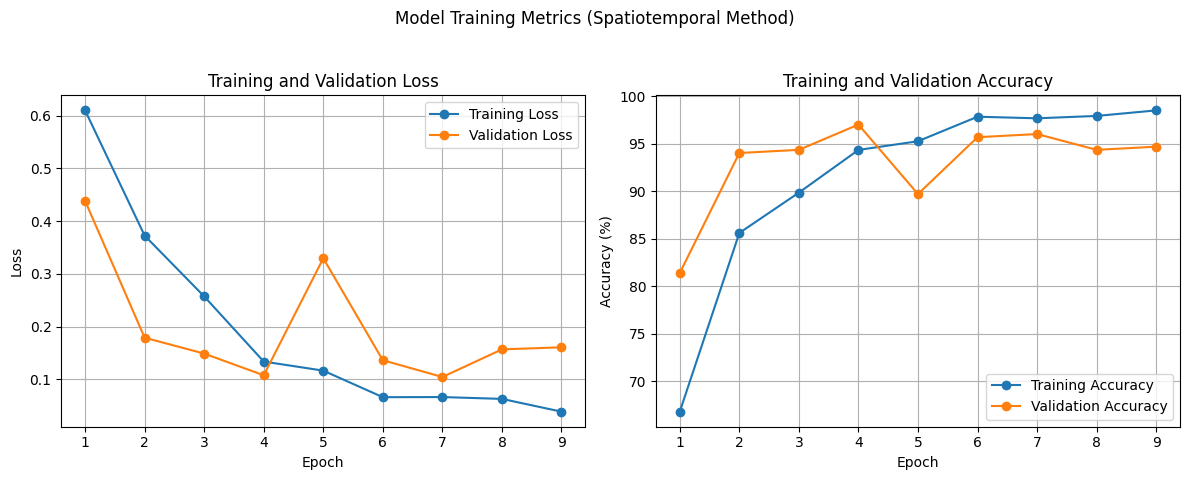

Metrics plot saved to training_metrics_spatiotemporal.png

Loading best model from ./model_checkpoints_spatiotemporal/best_model_xception.pth for final evaluation...


Evaluating on Test Set: 100%|██████████| 94/94 [01:04<00:00,  1.46it/s]



--- Test Set Evaluation ---
              precision    recall  f1-score   support

        REAL       0.96      0.94      0.95       176
        FAKE       0.95      0.96      0.96       200

    accuracy                           0.95       376
   macro avg       0.96      0.95      0.95       376
weighted avg       0.95      0.95      0.95       376



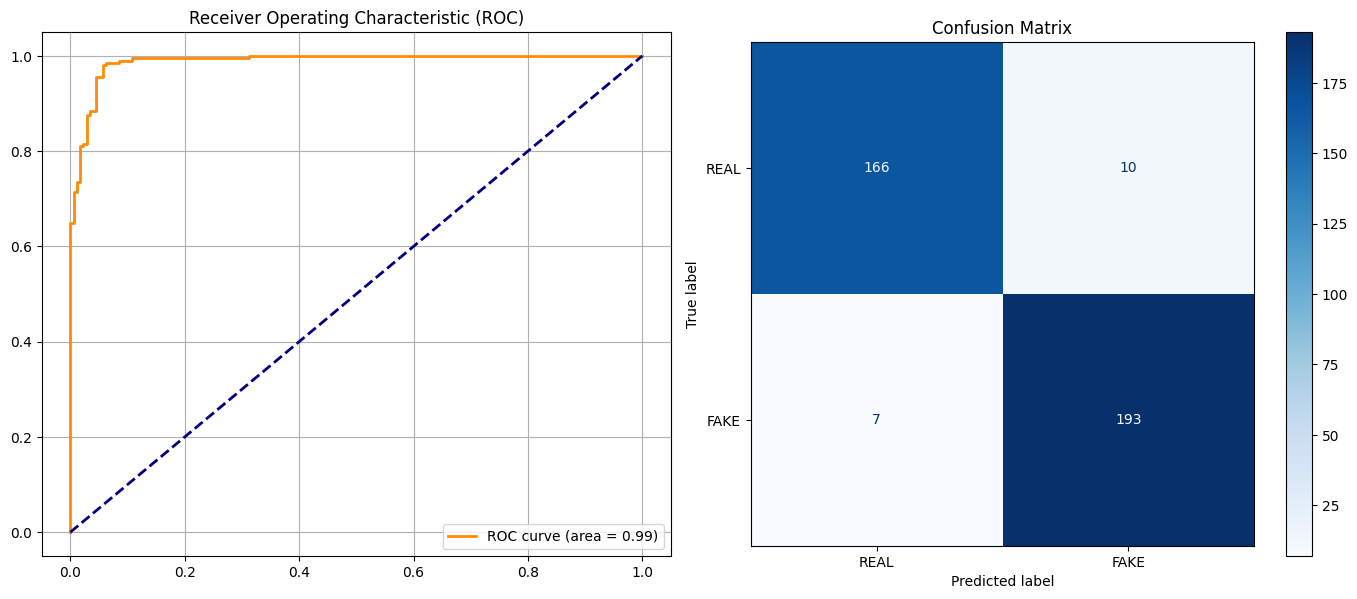

Test evaluation plots saved to test_evaluation_results_spatiotemporal.png


In [12]:
# --- Main Execution ---
if __name__ == "__main__":
    X_train, X_val, X_test, y_train, y_val, y_test = prepare_video_sequences_dataset(CONFIG)
    print(f"Dataset prepared. Train sequences: {len(X_train)}, Val sequences: {len(X_val)}, Test sequences: {len(X_test)}")

    data_transforms = transforms.Compose([
        transforms.Resize((CONFIG["image_size"], CONFIG["image_size"])),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])

    train_dataset = VideoDataset(X_train, y_train, data_transforms)
    val_dataset = VideoDataset(X_val, y_val, data_transforms)
    test_dataset = VideoDataset(X_test, y_test, data_transforms)

    train_loader = DataLoader(train_dataset, batch_size=CONFIG["batch_size"], shuffle=True, num_workers=2)
    val_loader = DataLoader(val_dataset, batch_size=CONFIG["batch_size"], shuffle=False, num_workers=2)
    test_loader = DataLoader(test_dataset, batch_size=CONFIG["batch_size"], shuffle=False, num_workers=2)

    model = STA_Xception_ConvLSTM(model_name=CONFIG["model_name"]).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=CONFIG["learning_rate"], weight_decay=CONFIG["weight_decay"])

    model_save_dir = CONFIG["model_save_path"]
    os.makedirs(model_save_dir, exist_ok=True)
    best_model_path = os.path.join(model_save_dir, f"best_model_{CONFIG['model_name']}.pth")

    train_loss_history, val_loss_history, train_acc_history, val_acc_history = [], [], [], []
    best_val_accuracy, epochs_no_improve = 0, 0

    print(f"Starting training for {CONFIG['model_name']} with Spatiotemporal Attention and ConvLSTM...")
    for epoch in range(CONFIG["epochs"]):
        model.train()
        running_loss, train_correct, train_total = 0.0, 0, 0
        for sequences, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{CONFIG['epochs']}"):
            sequences, labels = sequences.to(device), labels.to(device)
            optimizer.zero_grad(); outputs = model(sequences); loss = criterion(outputs, labels)
            loss.backward(); optimizer.step()
            running_loss += loss.item(); _, predicted = torch.max(outputs.data, 1)
            train_total += labels.size(0); train_correct += (predicted == labels).sum().item()

        epoch_loss = running_loss / len(train_loader); epoch_train_acc = 100 * train_correct / train_total
        train_loss_history.append(epoch_loss); train_acc_history.append(epoch_train_acc)

        model.eval()
        val_correct, val_total, running_val_loss = 0, 0, 0.0
        with torch.no_grad():
            for sequences, labels in val_loader:
                sequences, labels = sequences.to(device), labels.to(device)
                outputs = model(sequences); val_loss = criterion(outputs, labels)
                running_val_loss += val_loss.item(); _, predicted = torch.max(outputs.data, 1)
                val_total += labels.size(0); val_correct += (predicted == labels).sum().item()

        epoch_val_acc = 100 * val_correct / val_total; epoch_val_loss = running_val_loss / len(val_loader)
        val_acc_history.append(epoch_val_acc); val_loss_history.append(epoch_val_loss)

        print(f"Epoch {epoch+1}/{CONFIG['epochs']}, Train Loss: {epoch_loss:.4f}, Train Acc: {epoch_train_acc:.2f}%, Val Loss: {epoch_val_loss:.4f}, Val Acc: {epoch_val_acc:.2f}%")

        if epoch_val_acc > best_val_accuracy:
            best_val_accuracy, epochs_no_improve = epoch_val_acc, 0
            torch.save(model.state_dict(), best_model_path)
            print(f"Validation accuracy improved! Saving best model to {best_model_path}")
        else:
            epochs_no_improve += 1
            print(f"Validation accuracy did not improve. Counter: {epochs_no_improve}/{CONFIG['early_stopping_patience']}")

        if epochs_no_improve >= CONFIG['early_stopping_patience']:
            print("Early stopping triggered."); break

    print("\n--- Training finished ---")
    plot_and_save_metrics(train_loss_history, val_loss_history, train_acc_history, val_acc_history)

    print(f"\nLoading best model from {best_model_path} for final evaluation...")
    model.load_state_dict(torch.load(best_model_path))
    evaluate_on_test_set(model, test_loader, device)


In [13]:
import torch
torch.save(model.state_dict(), "/kaggle/working/model_celebdfv2.pth")